# Урок 5. Feature Engineering, Feature Selection, part I

**Задание 0:**

**выбрать любую модель машнного обучения и зафиксировать любой тип валидации. Обучить базовую модель и зафиксировать базовое качество модели. В каждом следующем задании нужно будет обучить выбранную модель и оценивать ее качество на зафиксированной схеме валидации. После каждого задания, требуется сделать вывод о достигаемом качестве модели, по сравнению с качестом из предыдущего шага.**

In [1]:
from typing import List,Optional
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

import missingno as msno

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

In [6]:
DATA_PATH="Data"
def load_data(dataset_name,data_path=DATA_PATH):
    csv_path = os.path.join(data_path,dataset_name)
    data = pd.read_csv(csv_path)
    data.columns=[col.lower() for col in data.columns]
    print("shape = {} rows, {} cols".format(*data.shape))
    return data

In [7]:
train = load_data("assignment_2_train.csv")
test = load_data("assignment_2_test.csv")

shape = 180000 rows, 394 cols
shape = 100001 rows, 394 cols


In [5]:
train.describe()

,transactionid,isfraud,transactiondt,transactionamt,card1,card2,card3,card5,addr1,addr2,...,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339
count,1.800000e+05,180000.000000,1.800000e+05,180000.000000,180000.000000,177389.000000,179997.000000,179047.000000,160567.000000,160567.000000,...,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000,47996.000000
mean,3.077000e+06,0.028561,1.909818e+06,129.514237,9860.225806,368.326897,153.410374,200.363089,291.160444,86.559903,...,0.137074,74.962242,99.220468,85.778161,8.326725,18.404676,12.437524,26.798593,32.005349,28.492421
std,5.196167e+04,0.166570,1.039029e+06,206.515032,4910.778205,158.952840,11.529483,40.585532,102.250385,3.958070,...,0.642444,545.161980,668.223140,577.072150,84.616132,120.896921,99.305885,252.695682,284.870583,258.372941
min,2.987000e+06,0.000000,8.640000e+04,0.292000,1001.000000,100.000000,100.000000,100.000000,100.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.032000e+06,0.000000,1.091681e+06,44.000000,6019.000000,215.000000,150.000000,166.000000,204.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.077000e+06,0.000000,1.884075e+06,75.000000,9633.000000,375.000000,150.000000,226.000000,299.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.121999e+06,0.000000,2.693196e+06,125.000000,14182.000000,514.000000,150.000000,226.000000,330.000000,87.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3.166999e+06,1.000000,3.958317e+06,5278.950000,18396.000000,600.000000,231.000000,237.000000,540.000000,102.000000,...,15.000000,20750.000000,32250.000000,21250.000000,3100.000000,3350.000000,3250.000000,8250.000000,8250.000000,8250.000000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180000 entries, 0 to 179999
Columns: 394 entries, transactionid to v339
dtypes: float64(376), int64(4), object(14)
memory usage: 541.1+ MB


In [7]:
train.head()

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def get_data_with_numerical_features(ds, cols_todrop, missings_filling_mark="-9999"):
    numerical_features = ds.select_dtypes(exclude=["object"])
    print(f"count of numeric_features {numerical_features.shape[1]}")
    numerical_features = numerical_features.drop(cols_todrop, axis=1)
    #Заменяем пропуски на среднии
    if missings_filling_mark == "mean":
        numerical_features = numerical_features.fillna(numerical_features.mean())
    else:
        numerical_features = numerical_features.fillna(-9999)
    
    return numerical_features
    

In [7]:
def get_data_with_CBInnerE_categorical_features(ds,cols_todrop,target_name,handle_numerical_features:callable):
    data=handle_numerical_features(ds,cols_todrop)
    categorical_features = ds.select_dtypes(include=["object"])
    categorical_features=categorical_features.fillna('')
    data = pd.concat([data, categorical_features], axis=1)
    target=ds[target_name]
    cat_feats =[]
    for col in categorical_features.columns:
        cat_feats.append(col)

    return data,target,cat_feats

In [22]:
data,target,cat_feats=get_data_with_CBInnerE_categorical_features(train,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)

count of numeric_features 380


Hold-out валидация с разбиением на 3 выборки

In [23]:
x_train, x_valid = train_test_split(
    data, train_size=0.7, shuffle=True, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, shuffle=True, random_state=1
)

x_valid, x_test = train_test_split(
    x_valid, train_size=0.7, shuffle=True, random_state=27
)
y_valid, y_test = train_test_split(
    y_valid, train_size=0.7, shuffle=True, random_state=27
)

print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
print("x_test.shape = {} rows, {} cols".format(*x_test.shape))

x_train.shape = 125999 rows, 391 cols
x_valid.shape = 37800 rows, 391 cols
x_test.shape = 16201 rows, 391 cols


In [26]:
train_scores = pd.DataFrame({"isfraud": y_train}) 
valid_scores = pd.DataFrame({"isfraud": y_valid})
test_scores = pd.DataFrame({"isfraud": y_test})
LB_test_scores = pd.DataFrame({"isfraud": test["isfraud"]}) 

In [8]:
cb_params = {
    "n_estimators": 3000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 30,
    "verbose": 300,
    "max_depth": 8,
    "l2_leaf_reg": 100,
    "early_stopping_rounds": 150,
    "thread_count": 8,
    "random_seed": 42,
    "use_best_model": True,
    "learning_rate": 0.05   
}

In [28]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6525406	test1: 0.6508108	best: 0.6508108 (0)	total: 487ms	remaining: 24m 19s
300:	test: 0.9038906	test1: 0.8929323	best: 0.8929323 (300)	total: 1m 23s	remaining: 12m 32s
600:	test: 0.9126377	test1: 0.8998232	best: 0.8998232 (600)	total: 2m 47s	remaining: 11m 10s
900:	test: 0.9174181	test1: 0.9039143	best: 0.9039143 (900)	total: 4m 11s	remaining: 9m 46s
1200:	test: 0.9228969	test1: 0.9080268	best: 0.9080273 (1199)	total: 5m 35s	remaining: 8m 23s
1500:	test: 0.9268398	test1: 0.9109573	best: 0.9109589 (1496)	total: 7m 2s	remaining: 7m 1s
1800:	test: 0.9296113	test1: 0.9128148	best: 0.9128151 (1798)	total: 8m 29s	remaining: 5m 38s
2100:	test: 0.9322355	test1: 0.9145961	best: 0.9145961 (2100)	total: 9m 55s	remaining: 4m 14s
2400:	test: 0.9361012	test1: 0.9178013	best: 0.9178013 (2400)	total: 11m 23s	remaining: 2m 50s
2700:	test: 0.9394028	test1: 0.9205351	best: 0.9205354 (2699)	total: 12m 52s	remaining: 1m 25s
2999:	test: 0.9407350	test1: 0.9215477	best: 0.9215477 (2999)	total: 1

In [30]:
train_scores["CatBoost_gbtree_2"] = model_cb.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree_2"] = model_cb.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree_2"] = model_cb.predict_proba(x_test)[:,1]

In [9]:
def plot_curves(valid_scores_par: pd.DataFrame, train_scores_par: pd.DataFrame,target_name ) -> None:
    """
    Построение ROC-Curve для множества построенных моделей.

    Parameters
    ----------
    valid_scores: pandas.core.frame.DataFrame
        Датафрем с прогнозами модели на валидационной выборке.

    train_scores: pandas.core.frame.DataFrame
        Датафрейм с прогнозами модели на обучающей выборке.

    """
    fig = plt.figure(figsize=(15, 5))
    columns = set(valid_scores_par.columns) - set([target_name])

    plt.subplot(121)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Train ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            train_scores_par[target_name], train_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)

    plt.legend(loc="best")

    plt.subplot(122)
    plt.xlabel("FPR", size=14)
    plt.ylabel("TPR", size=14)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.title("Valid ROC curve")

    for feature in columns:
        fpr, tpr, _ = roc_curve(
            valid_scores_par[target_name], valid_scores_par[feature]
        )
        plt.plot(fpr, tpr, linewidth=2, label=feature)
    plt.legend(loc="best")

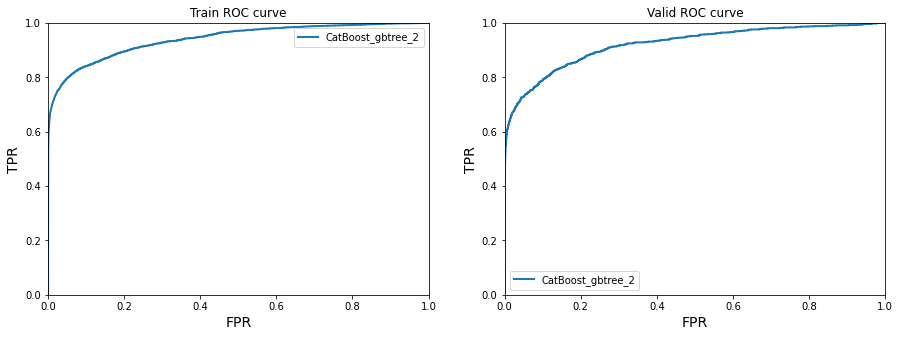

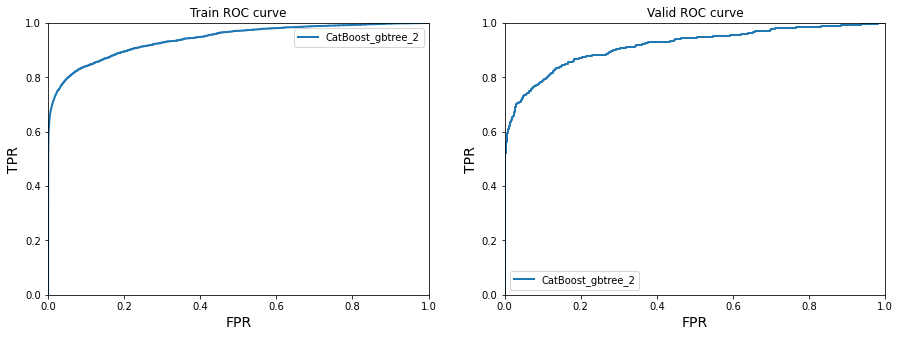

In [34]:
plot_curves(valid_scores, train_scores,"isfraud")
plot_curves(test_scores, train_scores,"isfraud")

In [35]:
test_predict_target=model_cb.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.730529647601505

In [36]:
test_data,test_target,cat_feats=get_data_with_CBInnerE_categorical_features(test,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)


count of numeric_features 380


In [38]:
test_predict_target=model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isfraud"].tolist(),test_predict_target)
test_roc_auc

0.6397355370590017

**Задание 1:** 

**признак TransactionDT - это смещение в секундах относительно базовой даты. Базовая дата - 2017-12-01, преобразовать признак TransactionDT в datetime, прибавив к базовой дате исходное значение признака. Из полученного признака выделить год, месяц, день недели, час, день.**

In [10]:
import datetime as dt

In [11]:
def set_date_columns(data,orig_date_col_name,base_dt_str):
    start_delta_sec = data[orig_date_col_name].min()
    base_date=pd.to_datetime(base_dt_str, infer_datetime_format=True)
    
    data["datetime_transactiondt"]=data[orig_date_col_name].apply(lambda x: base_date + pd.Timedelta(seconds=x))   
    data["year"] = data["datetime_transactiondt"].dt.year
    data["month_of_year"] = data["datetime_transactiondt"].dt.month    
    data["day_of_week"] = data["datetime_transactiondt"].dt.weekday
    data["hour"] = data["datetime_transactiondt"].dt.hour
    data["day"] = data["datetime_transactiondt"].dt.day

  

In [12]:
set_date_columns(train,'transactiondt','2017-12-01')

In [13]:
train

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v336,v337,v338,v339,datetime_transactiondt,year,month_of_year,day_of_week,hour,day
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,2017-12-02 00:00:00,2017,12,5,0,2
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,2017-12-02 00:00:01,2017,12,5,0,2
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,2017-12-02 00:01:09,2017,12,5,0,2
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,2017-12-02 00:01:39,2017,12,5,0,2
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,2017-12-02 00:01:46,2017,12,5,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,2018-01-15 19:30:17,2018,1,0,19,15
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,2018-01-15 19:30:37,2018,1,0,19,15
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,2018-01-15 19:30:41,2018,1,0,19,15
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,2018-01-15 19:31:00,2018,1,0,19,15


In [87]:
data,target,cat_feats=get_data_with_CBInnerE_categorical_features(train,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)

count of numeric_features 386


In [14]:
def get_train_valid_test_data(data,target):
    x_train, x_valid = train_test_split(
        data, train_size=0.7, shuffle=True, random_state=1
    )
    y_train, y_valid = train_test_split(
        target, train_size=0.7, shuffle=True, random_state=1
    )

    x_valid, x_test = train_test_split(
        x_valid, train_size=0.7, shuffle=True, random_state=27
    )
    y_valid, y_test = train_test_split(
        y_valid, train_size=0.7, shuffle=True, random_state=27
    )

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    print("x_valid.shape = {} rows, {} cols".format(*x_valid.shape))
    print("x_test.shape = {} rows, {} cols".format(*x_test.shape))
    return x_train, x_valid,x_test, y_train, y_valid,y_test

In [15]:
def get_scores_init_tables(y_train, y_valid,y_test,target_name="isfraud"):
    train_scores = pd.DataFrame({target_name: y_train}) 
    valid_scores = pd.DataFrame({target_name: y_valid})
    test_scores = pd.DataFrame({target_name: y_test})
    LB_test_scores = pd.DataFrame({target_name: test[target_name]}) 
    return train_scores,valid_scores,test_scores,LB_test_scores

In [94]:
x_train, x_valid,x_test, y_train, y_valid,y_test=get_train_valid_test_data(data,target)

x_train.shape = 125999 rows, 397 cols
x_valid.shape = 37800 rows, 397 cols
x_test.shape = 16201 rows, 397 cols


In [96]:
train_scores,valid_scores,test_scores,LB_test_scores=get_scores_init_tables(y_train, y_valid,y_test)

In [97]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.6844162	test1: 0.6741521	best: 0.6741521 (0)	total: 324ms	remaining: 16m 10s
300:	test: 0.9135340	test1: 0.9019697	best: 0.9019697 (300)	total: 1m 28s	remaining: 13m 12s
600:	test: 0.9216629	test1: 0.9073192	best: 0.9073192 (600)	total: 3m	remaining: 12m
900:	test: 0.9266467	test1: 0.9100720	best: 0.9100720 (900)	total: 4m 35s	remaining: 10m 41s
1200:	test: 0.9319513	test1: 0.9141151	best: 0.9141151 (1200)	total: 6m 16s	remaining: 9m 24s
1500:	test: 0.9358017	test1: 0.9168723	best: 0.9168723 (1500)	total: 8m 12s	remaining: 8m 11s
1800:	test: 0.9392015	test1: 0.9192130	best: 0.9192130 (1800)	total: 10m	remaining: 6m 39s
2100:	test: 0.9421244	test1: 0.9216694	best: 0.9216694 (2100)	total: 11m 41s	remaining: 5m
2400:	test: 0.9447190	test1: 0.9237520	best: 0.9237520 (2400)	total: 13m 22s	remaining: 3m 20s
2700:	test: 0.9469012	test1: 0.9250984	best: 0.9251070 (2693)	total: 15m 7s	remaining: 1m 40s
2999:	test: 0.9486025	test1: 0.9262547	best: 0.9262547 (2999)	total: 16m 53s	remai

In [98]:
train_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_test)[:,1]

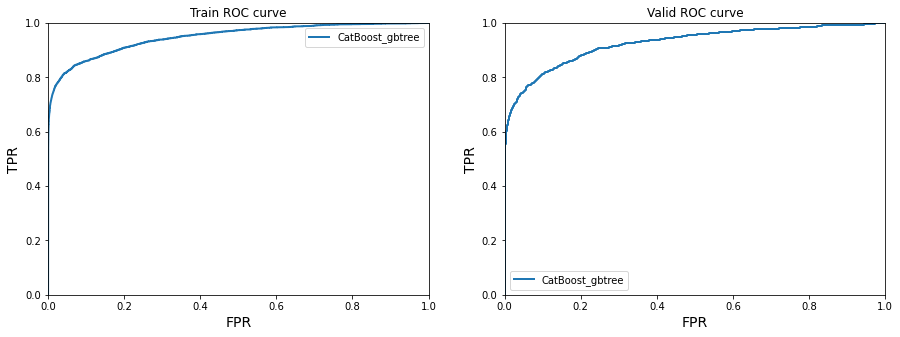

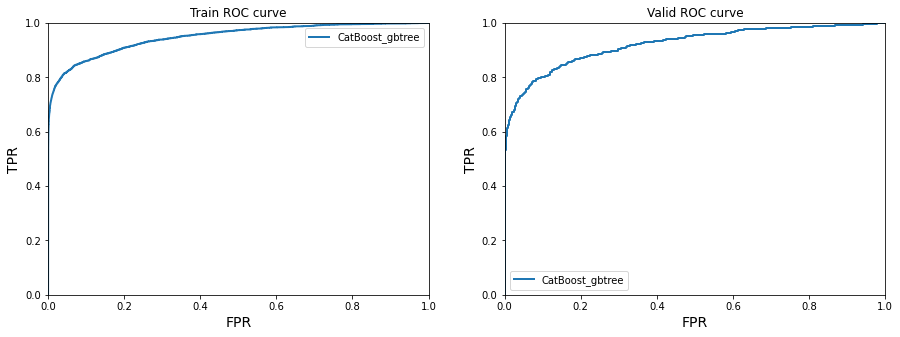

In [99]:
plot_curves(valid_scores, train_scores,"isfraud")
plot_curves(test_scores, train_scores,"isfraud")

In [100]:
test_predict_target=model_cb.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.7358974453984207

In [16]:
set_date_columns(test,'transactiondt','2017-12-01')

In [102]:
test_data,test_target,cat_feats=get_data_with_CBInnerE_categorical_features(test,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)


count of numeric_features 386


In [103]:
test_predict_target=model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isfraud"].tolist(),test_predict_target)
test_roc_auc

0.655921320303246

Выводы: в результате выполнения упражнения 1 произошло небольшое - во 2 знаке улучшение метрики roc-auc
    

**Задание 2: сделать конкатенацию признаков**
* card1 + card2;
* card1 + card2 + card_3 + card_5;
* card1 + card2 + card_3 + card_5 + addr1 + addr2**

**Рассматривать их как категориальных признаки.**

In [17]:
def concatenate(row,col_list):
    tmp=''
    for col_name in col_list:
        if not np.isnan(row[col_name]):           
            tmp=tmp+str(int(row[col_name]))
    
    new_col_name = tmp
    return new_col_name

In [18]:
def set_concat_features(ds,lists_table_columns,concatenate:callable):
    for columns_list in lists_table_columns:
        new_col_name=''
        for column in columns_list:            
            new_col_name+=(column+"_")
        ds[new_col_name]=ds.apply(lambda row:concatenate(row,columns_list),axis=1)
  

In [19]:
lists_table_columns=[["card1", "card2"],["card1", "card2","card3", "card5"],["card1", "card2","card3", "card5","addr1", "addr2"]]

In [20]:
set_concat_features(train,lists_table_columns,concatenate=concatenate)

In [21]:
train

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v339,datetime_transactiondt,year,month_of_year,day_of_week,hour,day,card1_card2_,card1_card2_card3_card5_,card1_card2_card3_card5_addr1_addr2_
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,2017-12-02 00:00:00,2017,12,5,0,2,13926,13926150142,1392615014231587
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,2017-12-02 00:00:01,2017,12,5,0,2,2755404,2755404150102,275540415010232587
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,2017-12-02 00:01:09,2017,12,5,0,2,4663490,4663490150166,466349015016633087
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,2017-12-02 00:01:39,2017,12,5,0,2,18132567,18132567150117,1813256715011747687
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,2017-12-02 00:01:46,2017,12,5,0,2,4497514,4497514150102,449751415010242087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,2018-01-15 19:30:17,2018,1,0,19,15,1877310,1877310150224,187731015022427287
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,2018-01-15 19:30:37,2018,1,0,19,15,10075514,10075514150224,1007551415022431587
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,2018-01-15 19:30:41,2018,1,0,19,15,6053122,6053122150195,605312215019533087
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,2018-01-15 19:31:00,2018,1,0,19,15,7726555,7726555150226,772655515022627287


In [243]:
data,target,cat_feats=get_data_with_CBInnerE_categorical_features(train,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)

count of numeric_features 386


In [244]:
x_train, x_valid,x_test, y_train, y_valid,y_test=get_train_valid_test_data(data,target)

x_train.shape = 125999 rows, 400 cols
x_valid.shape = 37800 rows, 400 cols
x_test.shape = 16201 rows, 400 cols


In [245]:
train_scores,valid_scores,test_scores,LB_test_scores=get_scores_init_tables(y_train, y_valid,y_test)

In [246]:
model_cb = cb.CatBoostClassifier(**cb_params)
model_cb.fit(x_train, 
             y_train, 
             eval_set=[(x_train, y_train), (x_valid, y_valid)], 
             cat_features=cat_feats,plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5227092	test1: 0.5151500	best: 0.5151500 (0)	total: 101ms	remaining: 5m 2s
300:	test: 0.9796707	test1: 0.9419740	best: 0.9419794 (290)	total: 1m 51s	remaining: 16m 37s
600:	test: 0.9843103	test1: 0.9460344	best: 0.9460348 (597)	total: 3m 52s	remaining: 15m 28s
900:	test: 0.9861045	test1: 0.9475379	best: 0.9475857 (882)	total: 5m 55s	remaining: 13m 47s
1200:	test: 0.9867479	test1: 0.9482483	best: 0.9482560 (1199)	total: 7m 56s	remaining: 11m 54s
1500:	test: 0.9877185	test1: 0.9495225	best: 0.9495422 (1492)	total: 9m 59s	remaining: 9m 58s
1800:	test: 0.9881676	test1: 0.9503395	best: 0.9503520 (1791)	total: 11m 59s	remaining: 7m 59s
2100:	test: 0.9884410	test1: 0.9507818	best: 0.9507818 (2100)	total: 14m 4s	remaining: 6m 1s
2400:	test: 0.9885267	test1: 0.9509146	best: 0.9509176 (2377)	total: 16m 3s	remaining: 4m
2700:	test: 0.9890226	test1: 0.9516162	best: 0.9516287 (2663)	total: 18m 8s	remaining: 2m
2999:	test: 0.9892397	test1: 0.9520193	best: 0.9520305 (2974)	total: 20m 15s	r

In [247]:
cat_feats

['productcd',
 'card4',
 'card6',
 'p_emaildomain',
 'r_emaildomain',
 'm1',
 'm2',
 'm3',
 'm4',
 'm5',
 'm6',
 'm7',
 'm8',
 'm9',
 'card1_card2_',
 'card1_card2_card3_card5_',
 'card1_card2_card3_card5_addr1_addr2_']

In [248]:
train_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_train)[:,1]
valid_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_valid)[:,1]
test_scores["CatBoost_gbtree"] = model_cb.predict_proba(x_test)[:,1]

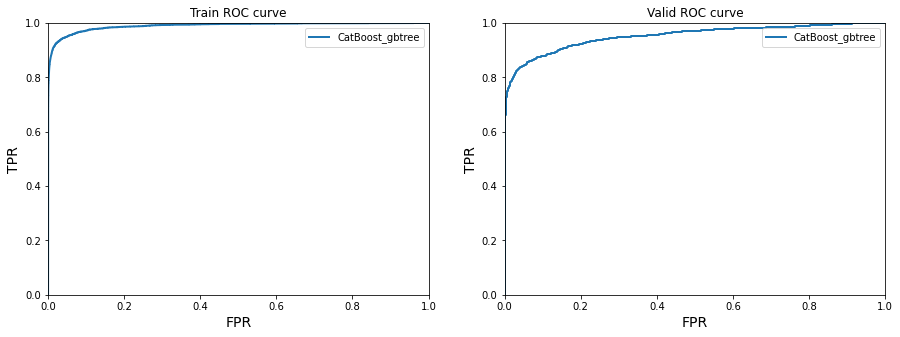

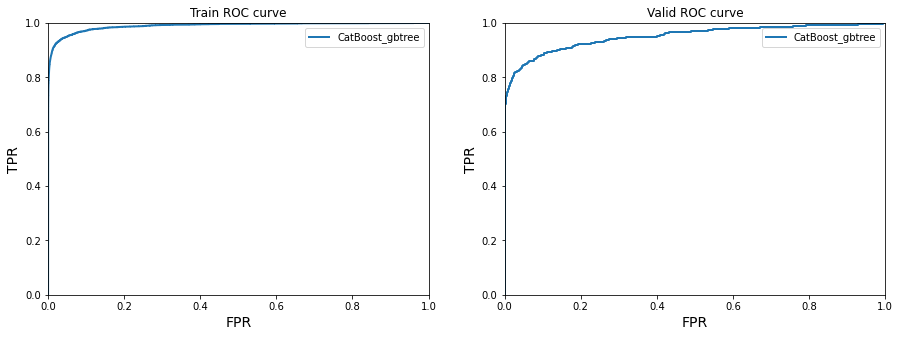

In [249]:
plot_curves(valid_scores, train_scores,"isfraud")
plot_curves(test_scores, train_scores,"isfraud")

In [250]:
test_predict_target=model_cb.predict(x_test)
test_roc_auc=roc_auc_score(y_test,test_predict_target)
test_roc_auc

0.8180026497613322

In [22]:
set_concat_features(test,lists_table_columns,concatenate=concatenate)

In [252]:
test_data,test_target,cat_feats=get_data_with_CBInnerE_categorical_features(test,["transactionid","transactiondt", "isfraud"],'isfraud',
                                                                  handle_numerical_features=get_data_with_numerical_features)


count of numeric_features 386


In [253]:
test_predict_target=model_cb.predict(test_data)
test_roc_auc=roc_auc_score(test["isfraud"].tolist(),test_predict_target)
test_roc_auc

0.6615814611046095

Выводы: в результате выполнения упражнения 2 произошло небольшое - во 2 знаке улучшение метрики roc-auc

**Задание 3:**

**Сделать FrequencyEncoder для признаков card1 - card6, addr1, addr2.**

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

In [9]:
class FrequencyEncoder( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 
    
    def fit_transform( self, X, y = None ):
        for feature_name in self._feature_names:
            X[feature_name]=X[feature_name].fillna(-1)            
            dt = (X.groupby(feature_name).size()) / len(X)            
            X[feature_name + "_encode"] = X[feature_name].apply(lambda x : dt[x])
        return X 
    

In [13]:
freqEncoder=FrequencyEncoder(["card1","card2","card3","card4","card5","card6", "addr1", "addr2"])

In [15]:
train

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v330,v331,v332,v333,v334,v335,v336,v337,v338,v339
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
train=freqEncoder.fit_transform(train)
train

,transactionid,isfraud,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,...,v338,v339,card1_encode,card2_encode,card3_encode,card4_encode,card5_encode,card6_encode,addr1_encode,addr2_encode
0,2987000,0,86400,68.50,W,13926,-1.0,150.0,discover,142.0,...,NaN,NaN,0.000061,0.014506,0.879722,0.013211,0.000272,0.317939,0.038156,0.876289
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,0.001244,0.006756,0.879722,0.302783,0.054433,0.317939,0.071367,0.876289
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,0.001428,0.060522,0.879722,0.657194,0.079844,0.681922,0.041217,0.876289
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,0.006600,0.009867,0.879722,0.302783,0.037106,0.681922,0.015411,0.876289
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.000011,0.030389,0.879722,0.302783,0.054433,0.317939,0.006967,0.876289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,3166995,0,3958217,39.00,W,1877,310.0,150.0,mastercard,224.0,...,NaN,NaN,0.000139,0.004856,0.879722,0.302783,0.128078,0.681922,0.032472,0.876289
179996,3166996,0,3958237,59.95,W,10075,514.0,150.0,mastercard,224.0,...,NaN,NaN,0.000483,0.030389,0.879722,0.302783,0.128078,0.681922,0.038156,0.876289
179997,3166997,0,3958241,34.00,W,6053,122.0,150.0,mastercard,195.0,...,NaN,NaN,0.001067,0.003167,0.879722,0.302783,0.030678,0.681922,0.041217,0.876289
179998,3166998,0,3958260,59.00,W,7726,555.0,150.0,visa,226.0,...,NaN,NaN,0.000028,0.069933,0.879722,0.657194,0.511961,0.681922,0.032472,0.876289
